# introduction
- given: many unlabeled data points and few labeled data points of a class $C$ known to be a minority
- goal: correctly label as many data points of $C$ and hard negatives from the other class with as few effort as necessary
- hard negatives: members from other class that are hard to distinguish from $C$
- method: Positive Unlabeled Learning (given: labeled data points of positive class and unlabeled data points from both classes; iteratively label most confident predictions as members of positive class; here supported by costly manual checks)

In [49]:
import numpy as np
from typing import List
from numpy.typing import NDArray
from sklearn import datasets
import copy 
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def train_pred(x_train: NDArray, y_train: NDArray, x_eval: NDArray, y_eval: NDArray, clf: XGBClassifier):
    clf.fit(x_train, y_train)
    pred = clf.predict(x_eval) 
    f1 = f1_score(y_pred=pred, y_true=y_eval)
    return f1, clf

def labeling_pseudo(x_train: NDArray, y_train: NDArray, clf: XGBClassifier, ids_neg: List[int], n_forward: int):
    # n_forward = amount of labeling candidates per iteration
    # set label of data point with most confident positive prediction to 1
    # ignore indices, where label is already known to be 1
    # ignore indices where label is already known to be 0
    probas = clf.predict_proba(x_train)[:, 1]
    ids_max = np.argsort(probas)[::-1]
    ids_max = [id for id in ids_max if (id not in np.where(y_train == 1)[0]) and (id not in ids_neg)]
    ids_max = ids_max[:min(len(ids_max), n_forward)]
    y_train_pseudo = copy.deepcopy(y_train)
    y_train_pseudo[ids_max] = 1 
    return y_train_pseudo, ids_max


def fetch_data(n: int = 10_000, share_pos_labeled: float = 0.05):  # 0.1
    """
    load data, 
    define class 1 as positive class and all others as "unlabeled",
    mask majority of positive labels to treat them as "unlabeled",
    split into train, val, test 
    """
    forest = datasets.fetch_covtype()
    x = forest.data
    y = forest.target
    y_gt = np.zeros_like(y)
    y_gt[np.where(y == 1)[0]] = 1
    ids_pos_gt = np.where(y_gt == 1)[0]
    x_train = x[:n]
    y_gt_train = y_gt[:n]
    y_train = np.zeros_like(y_gt_train)
    n_labeled = len(np.where(y_gt_train == 1)[0])
    y_train[np.where(y_gt_train == 1)[0][:int(n_labeled * share_pos_labeled)]] = 1
    x_test = x[n:n + n]
    y_test = y_gt[n:n + n]
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)
    return x_train, y_gt_train, y_train, x_val, y_val, x_test, y_test, ids_pos_gt

In [50]:
lookahead = 3  # lookahead iterations to (fuzzily) determine, if a set of pseudolabels is correct
budget = 2000  # amount of data points that can be labeled given time & cost limitations
n_forward = 100  # number of data ponts to be labeled per iteration

In [51]:
x_train, y_gt_train, y_train, x_val, y_val, x_test, y_test, ids_pos_gt = fetch_data()
print("train gt:", len(y_gt_train), y_gt_train.mean())
print("train:", len(y_train), y_train.mean())
print("val:", len(y_val), y_val.mean())
print("test:", len(y_test), y_test.mean())

clf = XGBClassifier()

f1s = [train_pred(x_train, y_train, x_val, y_val, clf=clf)[0]]
manual_checks = [0]
pos_finds = [y_train.sum()]
ids_neg = []
iters = 0
n_forward_inner = n_forward
while True:
    f1_initial, clf = train_pred(x_train, y_train, x_val, y_val, clf=clf)
    n_forward_inner = min(n_forward_inner, (budget - int(np.array(manual_checks).sum())))
    y_train_inner, ids_max = labeling_pseudo(x_train, y_train, clf, ids_neg, n_forward_inner)
    y_train_initial = copy.deepcopy(y_train_inner)
    # lookahead step
    for j in range(lookahead):
        clf.fit(x_train, y_train_inner)
        y_train_inner, _ = labeling_pseudo(x_train, y_train_inner, clf, ids_neg, n_forward_inner)
    f1_after = f1_score(y_pred=clf.predict(x_val), y_true=y_val)
    if f1_after >= f1_initial:
        f1s.append(f1_initial)
        # costly manual labeling
        manual_checks.append(len(ids_max))
        ids_pos = [id for id in ids_max if id in ids_pos_gt]
        pos_finds.append(len(ids_pos))
        ids_neg.extend([id for id in ids_max if id not in ids_pos_gt])
        # fix new labels 
        y_train[ids_pos] = 1
        recall = recall_score(y_pred=y_train, y_true=y_gt_train)
        n_forward_inner = n_forward
        # converge
        if np.sum(manual_checks) >= budget:
            break
        elif manual_checks[-1] == 0:
            break
    else:
        n_forward_inner -= 1
        if n_forward_inner == 0:
            break

train gt: 10000 0.1375
train: 10000 0.0068
val: 5000 0.1596
test: 5000 0.1538


In [52]:
# impact of hard negatives
ids_hn_pos = list(np.where(y_train == 1)[0]) + ids_neg
y_train_hn_pos = y_train[ids_hn_pos]
x_train_hn_pos = x_train[ids_hn_pos]
clf = XGBClassifier()
clf.fit(x_train_hn_pos, y_train_hn_pos)
print("test f1 with hard negatives:", f1_score(y_true=y_test, y_pred=clf.predict(x_test)))

# using random negatives as baseline
ids_rn_pos = list(np.where(y_train == 1)[0]) + list(np.where(y_train == 0)[0])[:len(ids_neg)]
y_train_rn_pos = y_train[ids_rn_pos]
x_train_rn_pos = x_train[ids_rn_pos]
clf = XGBClassifier()
clf.fit(x_train_rn_pos, y_train_rn_pos)
print("test f1 with random negatives:", f1_score(y_true=y_test, y_pred=clf.predict(x_test)))
# -> hard negatives lead to improved f1 with budget << len(data_set)

test f1 with hard negatives: 0.45481049562682213
test f1 with random negatives: 0.4599375650364204


In [53]:
# random run for comparison
x_train, y_gt_train, y_train, x_val, y_val, x_test, y_test, ids_pos_gt = fetch_data()

manual_checks_random = [0]
pos_finds_random = [y_train.sum()]
ids_neg = []
while True:
    probas = np.random.random(size=len(y_train))
    ids_max = np.argsort(probas)[::-1]
    ids_max = [id for id in ids_max if (id not in np.where(y_train == 1)[0]) and (id not in ids_neg)]
    ids_max = ids_max[:min(len(ids_max), n_forward)]
    manual_checks_random.append(len(ids_max))
    ids_pos = [id for id in ids_max if id in ids_pos_gt]
    pos_finds_random.append(len(ids_pos))
    ids_neg.extend([id for id in ids_max if id not in ids_pos_gt])
    y_train[ids_pos] = 1
    if np.sum(manual_checks_random) >= budget:
        break
    elif len(ids_max) == 0:
        break

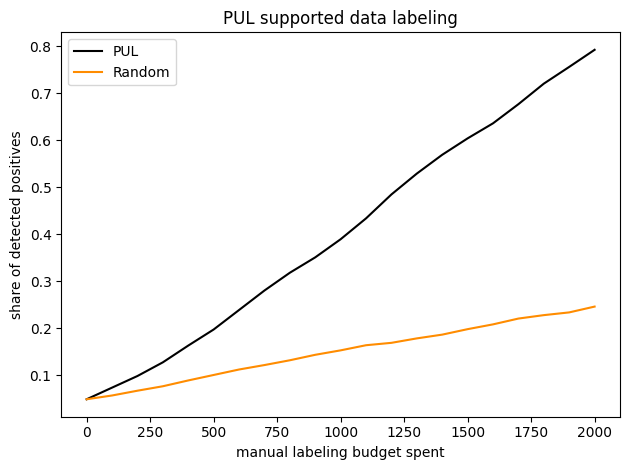

In [54]:
# plot

# random baseline
manual_checks_random_cumul = [manual_checks_random[0]]
for i in range(1, len(manual_checks_random)):
    manual_checks_random_cumul.append(manual_checks_random_cumul[i - 1] + manual_checks_random[i])
manual_checks_random_cumul = [i for i in manual_checks_random_cumul]

pos_finds_random_cumul = [pos_finds_random[0]]
for i in range(1, len(pos_finds_random)):
    pos_finds_random_cumul.append(pos_finds_random_cumul[i - 1] + pos_finds_random[i])
pos_finds_random_cumul = [i / y_gt_train.sum() for i in pos_finds_random_cumul]


# proposed method
manual_checks_cumul = [manual_checks[0]]
for i in range(1, len(manual_checks)):
    manual_checks_cumul.append(manual_checks_cumul[i - 1] + manual_checks[i])
manual_checks_cumul = [i for i in manual_checks_cumul]

pos_finds_cumul = [pos_finds[0]]
for i in range(1, len(pos_finds)):
    pos_finds_cumul.append(pos_finds_cumul[i - 1] + pos_finds[i])
pos_finds_cumul = [i / y_gt_train.sum() for i in pos_finds_cumul]

plt.plot(manual_checks_cumul, pos_finds_cumul, label="PUL", c="black")
plt.plot(manual_checks_random_cumul, pos_finds_random_cumul, label="Random", c="darkorange")
plt.xlabel("manual labeling budget spent")
plt.ylabel("share of detected positives")
plt.title("PUL supported data labeling")
plt.legend()
plt.tight_layout()

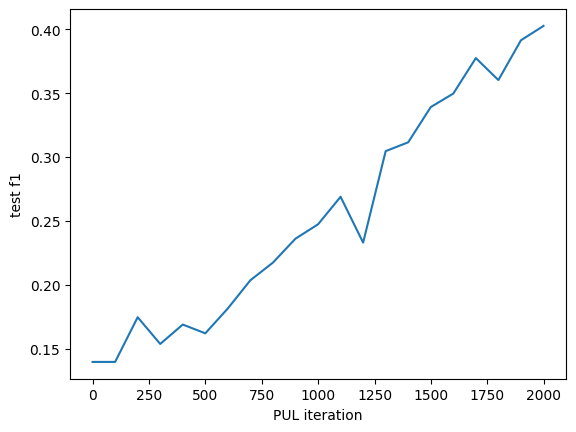

In [55]:
plt.plot([manual_checks_cumul[i] - pos_finds_cumul[i] for i in range(len(manual_checks))], f1s)
plt.xlabel("PUL iteration")
plt.ylabel("test f1")
plt.show()